In [ ]:
!pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 94.2 MB/s eta 0:00:00


In [37]:
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import pathlib


In [42]:
ROOT = pathlib.Path.cwd()
PRICES_CSV = ROOT / "prices.csv"

In [53]:
np.random.seed(7)

def generate_prices(T=48):
    hours = np.arange(T)
    base = 55 + 10*np.sin(2*np.pi*hours/24 - 0.8) + 6*np.sin(2*np.pi*hours/8)
    noise = np.random.normal(0, 3, T)
    price = np.clip(base + noise, 20, None).round(2)
    return pd.DataFrame({"hour": hours, "price_eur_per_mwh": price})

def load_prices():
    if PRICES_CSV.exists():
        df = pd.read_csv(PRICES_CSV)
        assert {"hour", "price_eur_per_mwh"}.issubset(df.columns)
        return df.sort_values("hour").reset_index(drop=True)
    df = generate_prices(48)
    df.to_csv(PRICES_CSV, index=False)
    return df

def solve():
    df = load_prices()
    T = len(df)
    prices = df["price_eur_per_mwh"].to_numpy()

    # Battery parameters
    capacity = 100.0           # MWh
    initial_soc = 50.0         # MWh
    charge_power_max = 20.0    # MW
    discharge_power_max = 20.0 # MW
    efficiency = 1.0           # no loss

    # Initialize model
    m = gp.Model("battery_dispatch")
    m.setParam("OutputFlag", 0)

    # Decision variables
    charge = m.addVars(T, lb=0, ub=charge_power_max, name="charge")
    discharge = m.addVars(T, lb=0, ub=discharge_power_max, name="discharge")
    soc = m.addVars(T + 1, lb=0, ub=capacity, name="soc")

    # Initial SOC
    m.addConstr(soc[0] == initial_soc, "initial_soc")

    y = m.addVars(T, vtype=GRB.BINARY, name="y_mode")

    m.addConstrs((charge[t] <= y[t] * charge_power_max for t in range(T)), "limit_charge")
    m.addConstrs((discharge[t] <= (1 - y[t]) * discharge_power_max for t in range(T)), "limit_discharge")


    # SOC dynamics
    for t in range(T):
        m.addConstr(
            soc[t + 1] == soc[t] + efficiency * charge[t] - (1 / efficiency) * discharge[t],
            f"soc_balance_{t}"
        )

    # Objective: maximize revenue = discharge * price - charge * price
    revenue = gp.quicksum(
        discharge[t] * prices[t] - charge[t] * prices[t] for t in range(T)
    )
    m.setObjective(revenue, GRB.MAXIMIZE)

    # Solve
    m.optimize()

    # Results
    charge_res = [charge[t].X for t in range(T)]
    discharge_res = [discharge[t].X for t in range(T)]
    soc_res = [soc[t].X for t in range(T + 1)]
    profit = m.objVal

    results = pd.DataFrame({
        "Hour": range(T),
        "Price (€/MWh)": prices,
        "Charge (MW)": charge_res,
        "Discharge (MW)": discharge_res,
        "SOC (MWh)": soc_res[:-1]
    })

    print(" Optimization complete!")
    print("Total Profit: €", round(profit, 2))

    # Save to CSV
    output_path = ROOT / "dispatch_results_fixed.csv"
    results.to_csv(output_path, index=False)
    print(f"Results saved to: {output_path}")
    return results, profit

In [54]:
results, profit = solve()
results.head(10)

 Optimization complete!
Total Profit: € 7279.6
Results saved to: /content/dispatch_results_fixed.csv


,Hour,Price (€/MWh),Charge (MW),Discharge (MW),SOC (MWh)
0,0,52.90,20.0,0.0,50.0
1,1,52.72,20.0,0.0,70.0
2,2,58.37,0.0,20.0,90.0
3,3,60.32,0.0,20.0,70.0
4,4,55.08,20.0,0.0,50.0
5,5,55.64,20.0,0.0,70.0
6,6,55.96,0.0,10.0,90.0
7,7,54.08,20.0,0.0,80.0
8,8,67.67,0.0,20.0,100.0
9,9,71.04,0.0,20.0,80.0


In [55]:
import matplotlib.pyplot as plt

def plot_results(results):
    fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

    # Plot electricity prices
    axs[0].plot(results["Hour"], results["Price (€/MWh)"], color='tab:blue')
    axs[0].set_ylabel("Price (€/MWh)")
    axs[0].set_title("Electricity Price")
    axs[0].grid(True)

    # Plot charge and discharge power
    axs[1].bar(results["Hour"], results["Charge (MW)"], label="Charge", color='tab:green', alpha=0.7)
    axs[1].bar(results["Hour"], -results["Discharge (MW)"], label="Discharge", color='tab:red', alpha=0.7)
    axs[1].set_ylabel("Power (MW)")
    axs[1].set_title("Battery Charge/Discharge")
    axs[1].legend()
    axs[1].grid(True)

    # Plot state of charge (SOC)
    axs[2].plot(results["Hour"], results["SOC (MWh)"], color='tab:purple')
    axs[2].set_xlabel("Hour")
    axs[2].set_ylabel("State of Charge (MWh)")
    axs[2].set_title("Battery State of Charge")
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()

 Optimization complete!
Total Profit: € 7279.6
Results saved to: /content/dispatch_results_fixed.csv


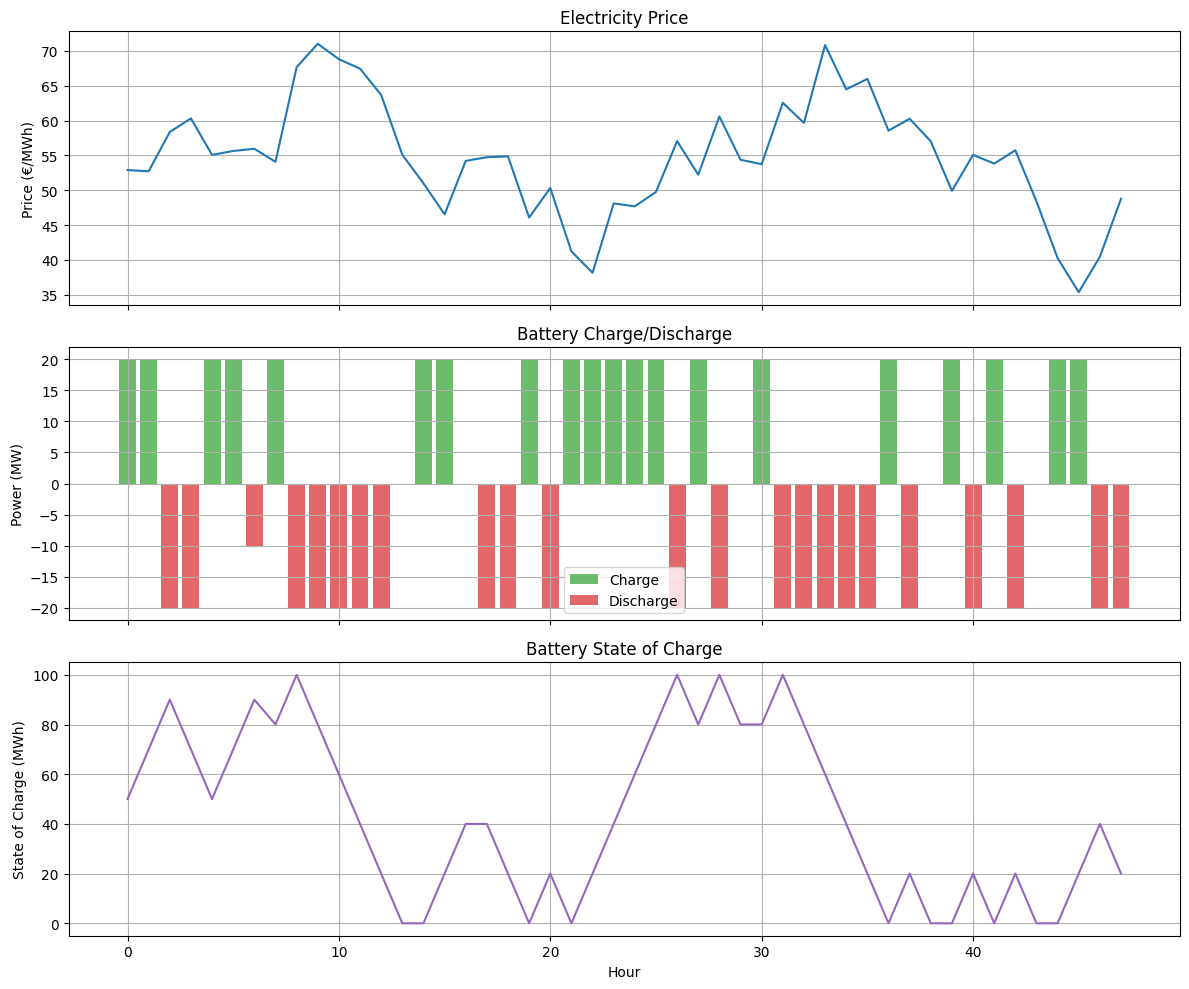

In [56]:
results, profit = solve()
plot_results(results)